# 🔍 Stock Screening & Portfolio Selection

## Professional Multi-Factor Investment Strategy

**Objective:** Systematically identify high-quality S&P 500 stocks using quantitative screening based on the Fama-French 5-Factor Model.

**Strategy:** Universal Multi-Factor Approach
- Works for all investor types
- Proven across 90+ years of market data  
- Removes emotional bias

**Output:** Top 50 ranked stocks for portfolio construction

---

**Author:** SmartPortfolio AI  
**Last Updated:** 2025-10-03


## 📚 1. Setup & Imports


In [1]:
# Standard libraries
import sys
from pathlib import Path
import os
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Financial data
import yfinance as yf

# Database
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Progress
from tqdm.notebook import tqdm

# Project setup
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))
load_dotenv(project_root / '.env')

# Custom modules
from utils.database_connector import DatabaseConnector

print("✅ Libraries imported")
print(f"📁 Project: {project_root.name}")


✅ Libraries imported
📁 Project: SmartPortfolio


## ⚙️ 2. Strategy Configuration

### Fama-French 5-Factor Model
- **Fundamental (40%)**: Company quality  
- **Momentum (25%)**: Price trends
- **Technical (20%)**: Entry timing
- **Risk (15%)**: Volatility control


In [2]:
CONFIG = {
    'STRATEGY_NAME': 'Universal Multi-Factor',
    'WEIGHTS': {
        'fundamental': 40,
        'momentum': 25,
        'technical': 20,
        'risk': 15,
    },
    'TOP_N': 50,
    'MIN_SCORE': 60,
    'MIN_MARKET_CAP': 1e9,
}

print("=" * 80)
print("📊 STRATEGY CONFIGURATION")
print("=" * 80)
print(f"Strategy: {CONFIG['STRATEGY_NAME']}")
print(f"Universe: S&P 500 (Min Cap: ${CONFIG['MIN_MARKET_CAP']/1e9:.0f}B)")
print(f"\nWeights:")
for k, v in CONFIG['WEIGHTS'].items():
    print(f"  • {k.capitalize():<15} {v:>3}%")
print(f"\nSelection: Top {CONFIG['TOP_N']} stocks, Score ≥ {CONFIG['MIN_SCORE']}")
print("=" * 80)


📊 STRATEGY CONFIGURATION
Strategy: Universal Multi-Factor
Universe: S&P 500 (Min Cap: $1B)

Weights:
  • Fundamental      40%
  • Momentum         25%
  • Technical        20%
  • Risk             15%

Selection: Top 50 stocks, Score ≥ 60


## 🔌 3. Database Connection


In [3]:
db = DatabaseConnector()
if db.test_connection():
    print("✅ Database connected")
else:
    raise Exception("❌ Connection failed")


2025-10-03 14:31:14,296 - INFO - Attempting connection with pymssql...
2025-10-03 14:31:14,316 - INFO - ✅ Database connection established
2025-10-03 14:31:14,375 - INFO - ✅ Database connection test passed


✅ Database connected


## 📊 4. Data Collection

Load three datasets:
1. Technical indicators
2. Price & momentum  
3. Fundamentals from yfinance


### 4.1 Technical Indicators


In [4]:
query_tech = """
WITH LatestDates AS (
    SELECT ticker, MAX(date) as max_date
    FROM market.technical_indicators GROUP BY ticker
)
SELECT t.ticker, t.date, t.sma_20, t.sma_50, t.sma_200,
       t.rsi_14, t.macd, t.macd_signal, t.adx_14, t.atr_14,
       t.volatility_20, t.trend_signal, t.golden_cross, t.death_cross
FROM market.technical_indicators t
INNER JOIN LatestDates ld ON t.ticker = ld.ticker AND t.date = ld.max_date
"""

df_tech = pd.read_sql(query_tech, db.engine)
print(f"✅ Loaded {len(df_tech)} stocks with technical indicators")
display(df_tech.head(3))


✅ Loaded 503 stocks with technical indicators


,ticker,date,sma_20,sma_50,sma_200,rsi_14,macd,macd_signal,adx_14,atr_14,volatility_20,trend_signal,golden_cross,death_cross
0,A,2025-10-01,126.3625,121.6113,122.4185,72.6085,1.9752,1.4326,20.0547,3.3646,0.024199,bullish,False,False
1,AAPL,2025-10-01,243.9735,230.9171,221.6899,68.8552,7.4353,6.7339,33.2153,4.6857,0.016514,bullish,False,False
2,ABBV,2025-10-01,219.9265,208.6126,191.6840,83.8377,6.4216,5.0468,38.5952,4.7386,0.018220,bullish,False,False


### 4.2 Price & Momentum


In [5]:
# Get company info from sp500_tickers, price data from daily_prices
query_prices = """
WITH LatestPrices AS (
    SELECT ticker, MAX(date) as max_date 
    FROM market.daily_prices 
    GROUP BY ticker
),
PriceData AS (
    SELECT 
        p.ticker,
        p.[close] as close_current, 
        p.volume as volume_current,
        LAG(p.[close], 5) OVER (PARTITION BY p.ticker ORDER BY p.date) as close_5d,
        LAG(p.[close], 20) OVER (PARTITION BY p.ticker ORDER BY p.date) as close_1m,
        LAG(p.[close], 60) OVER (PARTITION BY p.ticker ORDER BY p.date) as close_3m,
        LAG(p.[close], 125) OVER (PARTITION BY p.ticker ORDER BY p.date) as close_6m,
        AVG(p.volume) OVER (PARTITION BY p.ticker ORDER BY p.date 
            ROWS BETWEEN 19 PRECEDING AND CURRENT ROW) as avg_volume_20d,
        p.date as date_current
    FROM market.daily_prices p
)
SELECT 
    pd.ticker,
    t.company_name,
    t.sector,
    t.industry,
    pd.close_current,
    pd.volume_current,
    pd.close_5d,
    pd.close_1m,
    pd.close_3m,
    pd.close_6m,
    pd.avg_volume_20d,
    (pd.close_current - pd.close_5d) / NULLIF(pd.close_5d, 0) as return_1w,
    (pd.close_current - pd.close_1m) / NULLIF(pd.close_1m, 0) as return_1m,
    (pd.close_current - pd.close_3m) / NULLIF(pd.close_3m, 0) as return_3m,
    (pd.close_current - pd.close_6m) / NULLIF(pd.close_6m, 0) as return_6m
FROM PriceData pd
INNER JOIN LatestPrices lp ON pd.ticker = lp.ticker AND pd.date_current = lp.max_date
LEFT JOIN market.sp500_tickers t ON pd.ticker = t.ticker
WHERE pd.close_6m IS NOT NULL 
  AND pd.close_current > 0
  AND pd.volume_current > 0
ORDER BY pd.ticker
"""

df_prices = pd.read_sql(query_prices, db.engine)

# Note: Market cap will be fetched from yfinance in the fundamentals section

print(f"✅ Loaded {len(df_prices)} stocks with price data")
print(f"   Avg 6M return: {df_prices['return_6m'].mean()*100:.2f}%")
display(df_prices.head(3))


✅ Loaded 503 stocks with price data
   Avg 6M return: 11.56%


,ticker,company_name,sector,industry,close_current,volume_current,close_5d,close_1m,close_3m,close_6m,avg_volume_20d,return_1w,return_1m,return_3m,return_6m
0,A,Agilent Technologies,Health Care,Life Sciences Tools & Services,138.58,4333300,124.1307,124.9691,120.7675,115.5143,1837450,0.116404,0.108914,0.147494,0.199678
1,AAPL,Apple Inc.,Information Technology,"Technology Hardware, Storage & Peripherals",255.45,48713900,252.3100,238.4700,209.7719,223.3433,60187345,0.012445,0.071204,0.217751,0.143755
2,ABBV,AbbVie,Health Care,Biotechnology,244.38,12243100,219.9900,211.8600,188.1450,201.5701,5983720,0.110869,0.153498,0.298892,0.212382


### 4.3 Fundamentals


In [6]:
print("🔄 Fetching fundamentals (2-3 mins)...")
tickers = df_tech['ticker'].tolist()
fundamentals = []

for ticker in tqdm(tickers):
    try:
        info = yf.Ticker(ticker).info
        fundamentals.append({
            'ticker': ticker,
            'market_cap': info.get('marketCap', np.nan),
            'pe_ratio': info.get('trailingPE', np.nan),
            'pb_ratio': info.get('priceToBook', np.nan),
            'profit_margin': info.get('profitMargins', np.nan),
            'roe': info.get('returnOnEquity', np.nan),
            'debt_to_equity': info.get('debtToEquity', np.nan),
            'current_ratio': info.get('currentRatio', np.nan),
            'revenue_growth': info.get('revenueGrowth', np.nan),
            'earnings_growth': info.get('earningsGrowth', np.nan),
            'beta': info.get('beta', np.nan),
        })
    except:
        fundamentals.append({'ticker': ticker})

df_fund = pd.DataFrame(fundamentals)
print(f"✅ Fetched {len(df_fund)} stocks")
display(df_fund.head(3))


🔄 Fetching fundamentals (2-3 mins)...


  0%|          | 0/503 [00:00<?, ?it/s]

✅ Fetched 503 stocks


,ticker,market_cap,pe_ratio,pb_ratio,profit_margin,roe,debt_to_equity,current_ratio,revenue_growth,earnings_growth,beta
0,A,40265564160,33.107227,6.323124,0.17973,0.19881,56.421,2.248,0.101,0.216,1.262
1,AAPL,3833138774016,39.253950,58.291800,0.24296,1.49814,154.486,0.868,0.096,0.121,1.094
2,ABBV,415256018944,111.405220,-2260.240500,0.06451,1.12854,NaN,0.736,0.066,-0.324,0.507


### 4.4 Merge Data


In [7]:
df = df_tech.merge(df_prices, on='ticker', how='inner')
df = df.merge(df_fund, on='ticker', how='left')
print(f"✅ Combined: {len(df)} stocks × {len(df.columns)} features")


✅ Combined: 503 stocks × 38 features


## 🎯 5. Multi-Factor Scoring

Calculate 4 scores (0-100 each):
1. Fundamental - Company quality
2. Momentum - Price strength
3. Technical - Entry timing
4. Risk - Volatility profile


### 5.1 Fundamental Score (40%)


In [18]:
def score_fundamentals(df):
    df = df.copy()
    df['fund_score'] = 0.0
    
    for col in ['pe_ratio', 'pb_ratio', 'profit_margin', 'roe', 'debt_to_equity', 'current_ratio', 'revenue_growth', 'earnings_growth']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Valuation (25 pts)
    val = pd.Series(0, index=df.index)
    val[(df['pe_ratio'] > 0) & (df['pe_ratio'] < 15)] = 13
    val[(df['pe_ratio'] >= 15) & (df['pe_ratio'] < 25)] = 10
    val[(df['pe_ratio'] >= 25) & (df['pe_ratio'] < 35)] = 6
    val[df['pe_ratio'] >= 35] = 2
    val[(df['pb_ratio'] > 0) & (df['pb_ratio'] < 2)] += 12
    val[(df['pb_ratio'] >= 2) & (df['pb_ratio'] < 4)] += 8
    val[(df['pb_ratio'] >= 4) & (df['pb_ratio'] < 8)] += 4
    df['fund_score'] += val
    
    # Profitability (40 pts)
    prof = pd.Series(0, index=df.index)
    prof[df['roe'] >= 0.20] = 20
    prof[(df['roe'] >= 0.15) & (df['roe'] < 0.20)] = 16
    prof[(df['roe'] >= 0.10) & (df['roe'] < 0.15)] = 10
    prof[(df['roe'] > 0) & (df['roe'] < 0.10)] = 4
    prof[df['profit_margin'] >= 0.20] += 20
    prof[(df['profit_margin'] >= 0.10) & (df['profit_margin'] < 0.20)] += 14
    prof[(df['profit_margin'] >= 0.05) & (df['profit_margin'] < 0.10)] += 8
    prof[(df['profit_margin'] > 0) & (df['profit_margin'] < 0.05)] += 2
    df['fund_score'] += prof
    
    # Growth (20 pts)
    growth = pd.Series(0, index=df.index)
    growth[df['revenue_growth'] >= 0.15] = 10
    growth[(df['revenue_growth'] >= 0.08) & (df['revenue_growth'] < 0.15)] = 7
    growth[(df['revenue_growth'] > 0) & (df['revenue_growth'] < 0.08)] = 3
    growth[df['earnings_growth'] >= 0.15] += 10
    growth[(df['earnings_growth'] >= 0.08) & (df['earnings_growth'] < 0.15)] += 7
    growth[(df['earnings_growth'] > 0) & (df['earnings_growth'] < 0.08)] += 3
    df['fund_score'] += growth
    
    # Health (15 pts)
    health = pd.Series(0, index=df.index)
    health[df['debt_to_equity'] < 50] = 8
    health[(df['debt_to_equity'] >= 50) & (df['debt_to_equity'] < 100)] = 5
    health[df['current_ratio'] >= 2.0] += 7
    health[(df['current_ratio'] >= 1.5) & (df['current_ratio'] < 2.0)] += 5
    df['fund_score'] += health
    df['fund_score'].fillna(df['fund_score'].median(), inplace=True)
    
    return df

df = score_fundamentals(df)
print(f"✅ Fundamental: Mean={df['fund_score'].mean():.1f}")
display(df.nlargest(10, 'fund_score')[['ticker', 'company_name', 'fund_score', 'roe', 'pe_ratio']])


✅ Fundamental: Mean=51.8


,ticker,company_name,fund_score,roe,pe_ratio
0,NEM,Newmont,93.0,0.20285,15.759058
3,MU,Micron Technology,89.0,0.17199,24.701580
1,GRMN,Garmin,85.0,0.20733,31.811806
2,MPWR,Monolithic Power Systems,85.0,0.66500,24.169847
72,SYF,Synchrony Financial,85.0,0.20233,8.662212
84,CF,CF Industries,85.0,0.19795,11.815203
14,QCOM,Qualcomm,83.0,0.44615,16.346191
166,CTRA,Coterra,83.0,0.11420,11.196173
218,DECK,Deckers Brands,83.0,0.43579,15.913978
279,CTSH,Cognizant,83.0,0.16693,13.683570


### 5.2 Momentum Score (25%)


In [19]:
def score_momentum(df):
    df = df.copy()
    df['momentum_score'] = 0.0
    
    for col in ['return_1w', 'return_1m', 'return_3m', 'return_6m', 'volume_current', 'avg_volume_20d']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 6M return (40 pts)
    df.loc[df['return_6m'] >= 0.30, 'momentum_score'] += 40
    df.loc[(df['return_6m'] >= 0.15) & (df['return_6m'] < 0.30), 'momentum_score'] += 32
    df.loc[(df['return_6m'] >= 0.05) & (df['return_6m'] < 0.15), 'momentum_score'] += 20
    df.loc[(df['return_6m'] >= 0) & (df['return_6m'] < 0.05), 'momentum_score'] += 10
    
    # 3M return (30 pts)
    df.loc[df['return_3m'] >= 0.20, 'momentum_score'] += 30
    df.loc[(df['return_3m'] >= 0.10) & (df['return_3m'] < 0.20), 'momentum_score'] += 24
    df.loc[(df['return_3m'] >= 0) & (df['return_3m'] < 0.10), 'momentum_score'] += 14
    
    # 1M return (20 pts)
    df.loc[df['return_1m'] >= 0.10, 'momentum_score'] += 20
    df.loc[(df['return_1m'] >= 0.05) & (df['return_1m'] < 0.10), 'momentum_score'] += 16
    df.loc[(df['return_1m'] >= 0) & (df['return_1m'] < 0.05), 'momentum_score'] += 10
    
    # Volume (10 pts)
    vol_ratio = df['volume_current'] / df['avg_volume_20d']
    df.loc[vol_ratio >= 1.5, 'momentum_score'] += 10
    df.loc[(vol_ratio >= 1.2) & (vol_ratio < 1.5), 'momentum_score'] += 7
    
    return df

df = score_momentum(df)
print(f"✅ Momentum: Mean={df['momentum_score'].mean():.1f}")
display(df.nlargest(10, 'momentum_score')[['ticker', 'company_name', 'momentum_score', 'return_6m']])


✅ Momentum: Mean=39.0


,ticker,company_name,momentum_score,return_6m
137,WDC,Western Digital,100.0,2.135128
195,STX,Seagate Technology,100.0,2.028738
206,DELL,Dell Technologies,100.0,0.586654
3,MU,Micron Technology,97.0,1.057804
4,KLAC,KLA Corporation,97.0,0.652677
5,LRCX,Lam Research,97.0,0.943996
35,IBKR,Interactive Brokers,93.0,0.582772
157,ABBV,AbbVie,92.0,0.212382
256,IQV,IQVIA,92.0,0.168722
315,AES,AES Corporation,92.0,0.270636


### 5.3 Technical Score (20%)


In [20]:
def score_technical(df):
    df = df.copy()
    df['tech_score'] = 0.0
    
    for col in ['rsi_14', 'macd', 'macd_signal', 'adx_14']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Trend (35 pts)
    df.loc[df['trend_signal'] == 'bullish', 'tech_score'] += 35
    df.loc[df['trend_signal'] == 'neutral', 'tech_score'] += 18
    df.loc[df['trend_signal'] == 'bearish', 'tech_score'] += 5
    
    # RSI (25 pts)
    rsi = pd.Series(0, index=df.index)
    rsi[(df['rsi_14'] >= 45) & (df['rsi_14'] <= 55)] = 25
    rsi[((df['rsi_14'] >= 40) & (df['rsi_14'] < 45)) | ((df['rsi_14'] > 55) & (df['rsi_14'] <= 60))] = 20
    df['tech_score'] += rsi
    
    # MACD (20 pts)
    df.loc[(df['macd'] > df['macd_signal']) & (df['macd'] > 0), 'tech_score'] += 20
    df.loc[(df['macd'] > df['macd_signal']) & (df['macd'] <= 0), 'tech_score'] += 14
    
    # ADX (20 pts)
    adx = pd.Series(0, index=df.index)
    adx[df['adx_14'] >= 40] = 20
    adx[(df['adx_14'] >= 25) & (df['adx_14'] < 40)] = 15
    df['tech_score'] += adx
    
    return df

df = score_technical(df)
print(f"✅ Technical: Mean={df['tech_score'].mean():.1f}")
display(df.nlargest(10, 'tech_score')[['ticker', 'company_name', 'tech_score', 'trend_signal']])


✅ Technical: Mean=49.5


,ticker,company_name,tech_score,trend_signal
13,BKR,Baker Hughes,95.0,bullish
22,LH,Labcorp,95.0,bullish
53,DGX,Quest Diagnostics,95.0,bullish
33,NDSN,Nordson Corporation,90.0,bullish
201,PSX,Phillips 66,90.0,bullish
23,BLK,BlackRock,80.0,bullish
47,STT,State Street Corporation,80.0,bullish
77,NTRS,Northern Trust,80.0,bullish
121,DVN,Devon Energy,80.0,bullish
136,ESS,Essex Property Trust,80.0,bullish


### 5.4 Risk Score (15%)


In [21]:
def score_risk(df):
    df = df.copy()
    df['risk_score'] = 0.0
    
    for col in ['volatility_20', 'beta', 'atr_14', 'close_current']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Volatility (50 pts)
    vol = pd.Series(0, index=df.index)
    vol[df['volatility_20'] < 0.015] = 50
    vol[(df['volatility_20'] >= 0.015) & (df['volatility_20'] < 0.025)] = 38
    vol[(df['volatility_20'] >= 0.025) & (df['volatility_20'] < 0.035)] = 24
    df['risk_score'] += vol
    
    # Beta (30 pts)
    beta = pd.Series(0, index=df.index)
    beta[(df['beta'] >= 0.8) & (df['beta'] <= 1.2)] = 30
    beta[((df['beta'] >= 0.6) & (df['beta'] < 0.8)) | ((df['beta'] > 1.2) & (df['beta'] <= 1.5))] = 22
    df['risk_score'] += beta
    
    # ATR (20 pts)
    atr_pct = df['atr_14'] / df['close_current']
    atr = pd.Series(0, index=df.index)
    atr[atr_pct < 0.025] = 20
    atr[(atr_pct >= 0.025) & (atr_pct < 0.04)] = 15
    df['risk_score'] += atr
    
    return df

df = score_risk(df)
print(f"✅ Risk: Mean={df['risk_score'].mean():.1f}")
display(df.nlargest(10, 'risk_score')[['ticker', 'company_name', 'risk_score', 'volatility_20']])


✅ Risk: Mean=79.1


,ticker,company_name,risk_score,volatility_20
1,GRMN,Garmin,100.0,0.012640
6,GOOGL,Alphabet Inc. (Class A),100.0,0.013566
7,GOOG,Alphabet Inc. (Class C),100.0,0.013354
10,FFIV,"F5, Inc.",100.0,0.014426
18,CMI,Cummins,100.0,0.012867
20,ALLE,Allegion,100.0,0.013161
22,LH,Labcorp,100.0,0.012334
24,BK,BNY Mellon,100.0,0.010086
32,ULTA,Ulta Beauty,100.0,0.014902
33,NDSN,Nordson Corporation,100.0,0.012873


### 5.5 Composite Score


In [22]:
# Weighted composite
df['composite_score'] = (
    df['fund_score'] * CONFIG['WEIGHTS']['fundamental'] / 100 +
    df['momentum_score'] * CONFIG['WEIGHTS']['momentum'] / 100 +
    df['tech_score'] * CONFIG['WEIGHTS']['technical'] / 100 +
    df['risk_score'] * CONFIG['WEIGHTS']['risk'] / 100
)

df['rank'] = df['composite_score'].rank(ascending=False, method='min').astype(int)
df = df.sort_values('composite_score', ascending=False).reset_index(drop=True)

print("=" * 80)
print("📊 FINAL RANKINGS")
print("=" * 80)
print(f"Composite: {df['composite_score'].mean():.1f} (max: {df['composite_score'].max():.1f})")
print("=" * 80)

display(df.head(20)[['rank', 'ticker', 'company_name', 'sector', 'composite_score', 
                      'fund_score', 'momentum_score', 'tech_score', 'risk_score']])


📊 FINAL RANKINGS
Composite: 52.2 (max: 82.7)


,rank,ticker,company_name,sector,composite_score,fund_score,momentum_score,tech_score,risk_score
0,1,NEM,Newmont,Materials,82.65,93.0,90.0,75.0,53.0
1,2,GRMN,Garmin,Consumer Discretionary,82.00,85.0,88.0,55.0,100.0
2,3,MPWR,Monolithic Power Systems,Information Technology,81.75,85.0,90.0,70.0,75.0
3,4,MU,Micron Technology,Information Technology,80.70,89.0,97.0,75.0,39.0
4,5,KLAC,KLA Corporation,Information Technology,78.10,69.0,97.0,75.0,75.0
5,6,LRCX,Lam Research,Information Technology,78.00,77.0,97.0,75.0,53.0
6,7,GOOGL,Alphabet Inc. (Class A),Communication Services,77.90,76.0,86.0,55.0,100.0
7,7,GOOG,Alphabet Inc. (Class C),Communication Services,77.90,76.0,86.0,55.0,100.0
8,9,FSLR,First Solar,Information Technology,77.35,74.0,90.0,70.0,75.0
9,10,MS,Morgan Stanley,Financials,76.60,72.0,80.0,70.0,92.0


## 🎯 6. Stock Selection


In [23]:
df_filtered = df[df['composite_score'] >= CONFIG['MIN_SCORE']].copy()
df_top = df_filtered.head(CONFIG['TOP_N'])

print("=" * 80)
print(f"🎯 {CONFIG['STRATEGY_NAME'].upper()}")
print("=" * 80)
print(f"Universe:     {len(df)} stocks")
print(f"Qualified:    {len(df_filtered)} ({len(df_filtered)/len(df)*100:.1f}%)")
print(f"Selected:     {len(df_top)}")
print("=" * 80)

cols = ['rank', 'ticker', 'company_name', 'sector', 'composite_score', 
        'close_current', 'roe', 'return_6m']
display(df_top[[c for c in cols if c in df_top.columns]])


🎯 UNIVERSAL MULTI-FACTOR
Universe:     503 stocks
Qualified:    141 (28.0%)
Selected:     50


,rank,ticker,company_name,sector,composite_score,close_current,roe,return_6m
0,1,NEM,Newmont,Materials,82.65,85.9500,0.20285,0.777953
1,2,GRMN,Garmin,Consumer Discretionary,82.00,255.1800,0.20733,0.179832
2,3,MPWR,Monolithic Power Systems,Information Technology,81.75,915.8700,0.66500,0.556646
3,4,MU,Micron Technology,Information Technology,80.70,182.1500,0.17199,1.057804
4,5,KLAC,KLA Corporation,Information Technology,78.10,1128.8700,1.00775,0.652677
5,6,LRCX,Lam Research,Information Technology,78.00,142.7900,0.58238,0.943996
6,7,GOOGL,Alphabet Inc. (Class A),Communication Services,77.90,244.9000,0.34829,0.562760
7,7,GOOG,Alphabet Inc. (Class C),Communication Services,77.90,245.5400,0.34829,0.548879
8,9,FSLR,First Solar,Information Technology,77.35,224.8200,0.15916,0.731782
9,10,MS,Morgan Stanley,Financials,76.60,156.8900,0.14128,0.335185


## 📊 7. Visualization


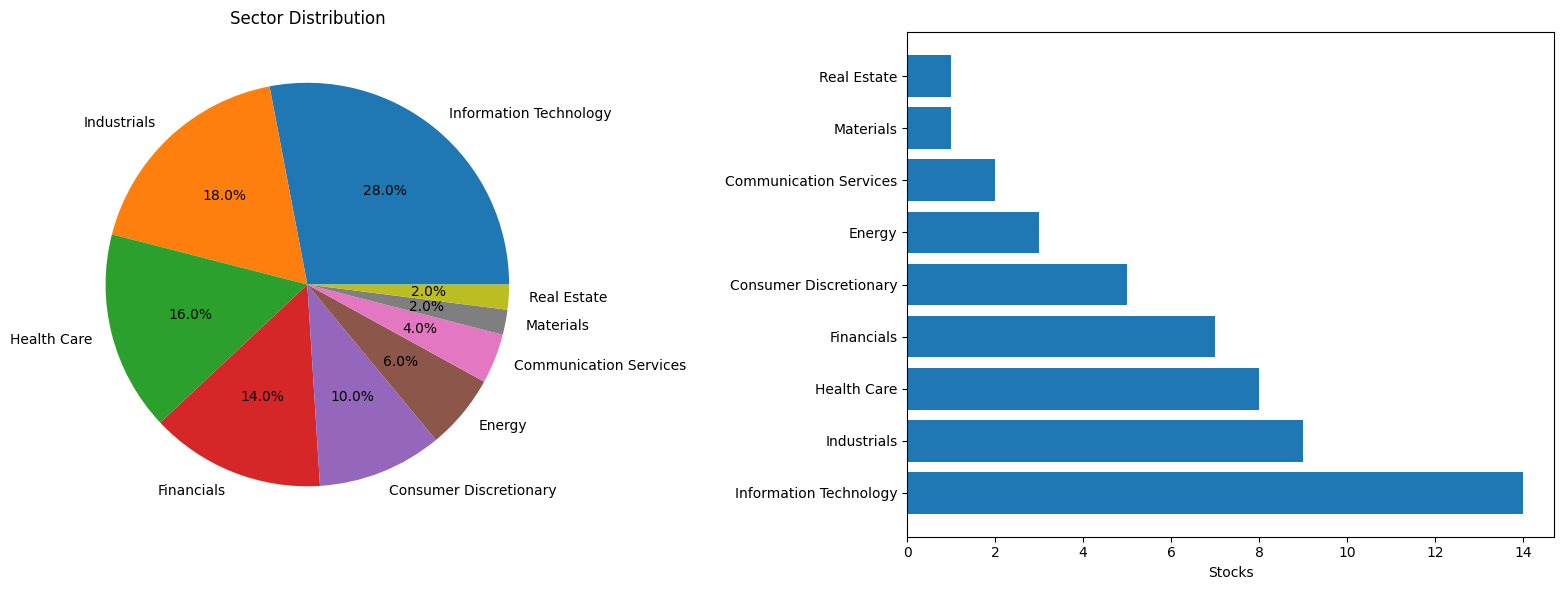

In [24]:
if len(df_top) > 0:
    sector_dist = df_top['sector'].value_counts()
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].pie(sector_dist.values, labels=sector_dist.index, autopct='%1.1f%%')
    ax[0].set_title('Sector Distribution')
    ax[1].barh(sector_dist.index, sector_dist.values)
    ax[1].set_xlabel('Stocks')
    plt.tight_layout()
    plt.show()


## 💾 8. Export Results


In [25]:
output_dir = project_root / 'data' / 'processed'
output_dir.mkdir(exist_ok=True, parents=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M')
output_file = output_dir / f"screening_universal_multi_factor_{timestamp}.csv"

cols = ['rank', 'ticker', 'company_name', 'sector', 'composite_score',
        'fund_score', 'momentum_score', 'tech_score', 'risk_score',
        'close_current', 'market_cap', 'pe_ratio', 'roe', 'return_6m']

df_top[[c for c in cols if c in df_top.columns]].to_csv(output_file, index=False)
print(f"✅ Exported to: {output_file.name}")


✅ Exported to: screening_universal_multi_factor_20251003_1435.csv


## 📋 9. Summary


In [27]:
print("=" * 80)
print("📊 SCREENING COMPLETE")
print("=" * 80)
print(f"Strategy: {CONFIG['STRATEGY_NAME']}")
print(f"\nResults:")
print(f"  Analyzed:  {len(df)}")
print(f"  Selected:  {len(df_top)}")

if len(df_top) > 0:
    print(f"\nMetrics:")
    print(f"  Avg Score:     {df_top['composite_score'].mean():.1f}/100")
    print(f"  Avg 6M Return: {df_top['return_6m'].mean()*100:.1f}%")
    print(f"  Avg ROE:       {df_top['roe'].mean()*100:.1f}%")
    
    print(f"\n🏆 Top 10:")
    for idx, row in df_top.head(10).iterrows():
        print(f"  {int(row['rank']):>2}. {row['ticker']:<5} {row['company_name']:<40} [{row['composite_score']:.1f}]")

print("=" * 80)
db.close()
print("✅ Complete!")


2025-10-03 14:35:43,145 - INFO - 🔌 Database connection closed


📊 SCREENING COMPLETE
Strategy: Universal Multi-Factor

Results:
  Analyzed:  503
  Selected:  50

Metrics:
  Avg Score:     72.4/100
  Avg 6M Return: 41.8%
  Avg ROE:       30.4%

🏆 Top 10:
   1. NEM   Newmont                                  [82.7]
   2. GRMN  Garmin                                   [82.0]
   3. MPWR  Monolithic Power Systems                 [81.8]
   4. MU    Micron Technology                        [80.7]
   5. KLAC  KLA Corporation                          [78.1]
   6. LRCX  Lam Research                             [78.0]
   7. GOOGL Alphabet Inc. (Class A)                  [77.9]
   7. GOOG  Alphabet Inc. (Class C)                  [77.9]
   9. FSLR  First Solar                              [77.3]
  10. MS    Morgan Stanley                           [76.6]
✅ Complete!
